# Testing optimum batch size for reading large trees

In [6]:
import uproot
import time
import pandas as pd
from tqdm import tqdm

def read_file_into_df(filepath, step_size=10000):
    with uproot.open(filepath) as tfile:
        if "myEvents" not in tfile:
            return pd.DataFrame()

        ttree = tfile["myEvents"]
        total_entries = ttree.num_entries

        if total_entries == 0:
            return pd.DataFrame()

        total_batches = (total_entries + step_size - 1) // step_size
        dfs = []

        with tqdm(total=total_batches, unit="batch",
                  bar_format="{l_bar}{bar}| {percentage:3.0f}% [{elapsed} < {remaining}, {n_fmt}/{total_fmt}]",
                  leave=True, ncols=100, desc="Reading", colour='green') as pbar:
            for batch in ttree.iterate(ttree.keys(), step_size=step_size, library="pd"):
                dfs.append(batch)
                pbar.update(1)

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def benchmark_read(filepath, batch_sizes):
    results = {}
    
    for batch_size in batch_sizes:
        start_time = time.time()
        # Read the file in chunks using read_file_into_df
        df = read_file_into_df(filepath, step_size=batch_size)
        elapsed_time = time.time() - start_time
        results[batch_size] = elapsed_time

    return results

print('Functions loaded.')

Functions loaded.


In [50]:
%%time

batch_sizes = [1500000, 2500000]
filepath = "../input_files/trees/tree_ee_Zwindow_2018UL_Feb27/tree_DYJetsToLL_M50.root"
benchmark_results = benchmark_read(filepath, batch_sizes)

Reading: 100%|███████████████████████████████████████████████████████████| 100% [02:23 < 00:00, 9/9]
Reading: 100%|███████████████████████████████████████████████████████████| 100% [02:46 < 00:00, 6/6]


CPU times: user 4min 56s, sys: 5.97 s, total: 5min 2s
Wall time: 5min 12s


In [51]:
display(benchmark_results)

{1500000: 144.77762126922607, 2500000: 168.00495290756226}

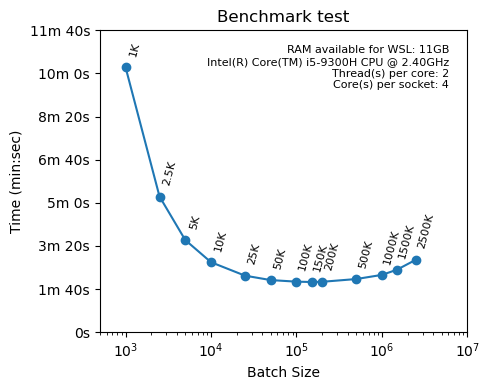

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

results = {1000: 614.7664835453033,
           2500: 314.5445897579193,
           5000: 213.63282179832458,
           10000: 162.20121693611145,
           25000: 130.95174384117126,
           50000: 120.70241022109985,
           100000: 117.05181527137756,
           150000: 116.23244118690491,
           200000: 116.76027464866638,
           500000: 123.11782646179199,
           1000000: 132.77071690559387,
           1500000: 144.77762126922607,
           2500000: 168.00495290756226
          }

def seconds_to_min_sec(x, pos):
    mins = int(x // 60)
    secs = int(x % 60)
    return f"{mins}m {secs}s" if mins else f"{secs}s"

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(list(results.keys()), list(results.values()), marker='o', linestyle='-')
ax.set_xlabel("Batch Size")
ax.set_ylabel("Time (min:sec)")
ax.set_title("Benchmark test")
ax.set_xscale("log")
ax.set_xlim(500, 10000000)
ax.set_ylim(0, 700)

# Format y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(seconds_to_min_sec))

for x, y in results.items():
    x_label = f"{x/1000:.1f}K" if x % 1000 != 0 else f"{int(x/1000)}K"
    x_disp, y_disp = ax.transData.transform((x, y))
    x_nudged = x_disp + 10
    y_nudged = y_disp + 10
    x_nudged_data, y_nudged_data = ax.transData.inverted().transform((x_nudged, y_nudged))
    ax.text(x_nudged_data, y_nudged_data, x_label, fontsize=8, va='bottom', ha='center', rotation=75)

# Add system information
info_text = (
    "RAM available for WSL: 11GB\n"
    "Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz\n"
    "Thread(s) per core: 2\n"
    "Core(s) per socket: 4"
)
ax.text(0.95, 0.95, info_text, transform=ax.transAxes, fontsize=8,
        va='top', ha='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

plt.tight_layout()
plt.savefig('benchmark.png', dpi=300)
plt.show()